In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd

from utility import get_all_files_paths
from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch

In [2]:
dataset_path="data/spec/GTZAN_646"
model_save_path="models/Echoes"
csv_save_path="output/Echoes_ouput/gtzan_encoded.csv"

encoded_space_dim=128

In [3]:
class AudioDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)
        data = data[np.newaxis, :, :]  # Add a channel dimension
        data = torch.tensor(data, dtype=torch.float32)
        
        # Extract label from file name
        filename = os.path.basename(file_path)
        label_str = filename.split('.')[0]
        label = self.label_to_index(label_str)
        
        return data, label

    @staticmethod
    def label_to_index(label_str):
        label_map = {'blues': 'blues', 'disco': 'disco', 'rock': 'rock', 'metal': 'metal', 'classical': 'classical', 'pop': 'pop', 'reggae':'reggae','country':'country', 'hiphop':'hiphop', 'jazz':'jazz'}  # Extend this as needed
        return label_map.get(label_str, -1)  # Return -1 if label is not found

genres = ['blues', 'disco', 'rock', 'metal', 'pop', 'classical', 'reggae', 'country','hiphop','jazz']

genre_file_paths = {genre: get_all_files_paths(f"{dataset_path}/{genre}", [".npy"]) for genre in genres}

train_file_paths = []
valid_file_paths = []
test_file_paths = []

for genre, paths in genre_file_paths.items():
    m = len(paths)
    test_size = int(m * 0.3)
    valid_size = int((m - test_size) * 0.1)
    train_size = m - test_size - valid_size
    
    paths = np.array(paths)
    np.random.shuffle(paths)
    
    train_paths = paths[:train_size]
    valid_paths = paths[train_size:train_size + valid_size]
    test_paths = paths[train_size + valid_size:]
    
    train_file_paths.extend(train_paths)
    valid_file_paths.extend(valid_paths)
    test_file_paths.extend(test_paths)

train_dataset = AudioDataset(train_file_paths)
valid_dataset = AudioDataset(valid_file_paths)
test_dataset = AudioDataset(test_file_paths)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 630
Validation set size: 70
Test set size: 300


In [4]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

device: mps


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=83968, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 16, 41))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): 

In [5]:
num_epochs = 100 # 100的时候valid loss会微微上升
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
	train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
	val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
	print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
	diz_loss['train_loss'].append(train_loss)
	diz_loss['val_loss'].append(val_loss)

	if (epoch+1)%10 ==0: 
		torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
		torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	# plot_ae_outputs(encoder,decoder,n=10)


 EPOCH 1/100 	 train loss 0.13064323365688324 	 val loss 0.03463005647063255

 EPOCH 2/100 	 train loss 0.02670660987496376 	 val loss 0.024429265409708023

 EPOCH 3/100 	 train loss 0.021042633801698685 	 val loss 0.021918324753642082

 EPOCH 4/100 	 train loss 0.019603503867983818 	 val loss 0.020215366035699844

 EPOCH 5/100 	 train loss 0.018950385972857475 	 val loss 0.01985062286257744

 EPOCH 6/100 	 train loss 0.018237989395856857 	 val loss 0.02503344975411892

 EPOCH 7/100 	 train loss 0.017282232642173767 	 val loss 0.02000577375292778

 EPOCH 8/100 	 train loss 0.01661701686680317 	 val loss 0.01822705566883087

 EPOCH 9/100 	 train loss 0.016703318804502487 	 val loss 0.017079945653676987

 EPOCH 10/100 	 train loss 0.016340646892786026 	 val loss 0.017052514478564262

 EPOCH 11/100 	 train loss 0.016366567462682724 	 val loss 0.017788605764508247

 EPOCH 12/100 	 train loss 0.01611262559890747 	 val loss 0.017495984211564064

 EPOCH 13/100 	 train loss 0.0160197727382183

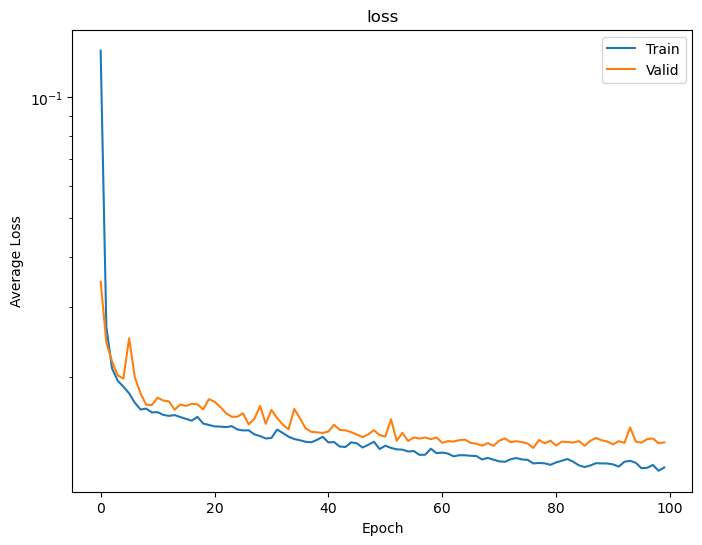

In [6]:
import matplotlib.pyplot as plt
# Plot losses
plt.figure(figsize=(8,6))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('loss')
plt.show()

In [7]:
encoder_path=f"{model_save_path}/encoder.pth"
decoder_path=f"{model_save_path}/decoder.pth"
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

encoder=load_encoder(encoder_path, encoded_space_dim)
# decoder=load_decoder(decoder_path, 64)
encoder.to(device)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=83968, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_f

In [8]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(csv_save_path, index=False)
encoded_samples

100%|██████████| 300/300 [00:01<00:00, 292.00it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 119,Enc. Variable 120,Enc. Variable 121,Enc. Variable 122,Enc. Variable 123,Enc. Variable 124,Enc. Variable 125,Enc. Variable 126,Enc. Variable 127,label
0,-5.296352,3.492911,-3.855151,1.483343,4.170522,-4.768251,4.840348,-0.673395,-0.371513,0.399566,...,-0.796081,0.336830,-6.499029,3.289304,-3.564773,3.931022,-2.047394,0.564227,0.452917,blues
1,-5.639840,4.905258,-3.611454,2.946600,4.205616,-6.773700,2.028044,-1.229272,2.342834,0.855631,...,1.465383,-1.249696,-4.982537,4.394707,-4.697774,3.041872,-0.596390,0.384316,1.272227,blues
2,-7.091572,5.461657,-5.955612,2.712031,3.074149,-7.071417,1.884906,-1.227479,2.145176,0.815440,...,-0.381544,-3.336067,-4.283538,5.509072,-6.998199,1.568969,-0.372282,2.976644,3.791420,blues
3,-2.231297,4.605365,-2.766119,-2.369617,4.624405,-2.017582,0.441607,1.934690,1.853933,0.290071,...,0.533112,0.457424,-6.098605,1.934608,-3.381132,4.664457,0.884084,-0.373162,-0.502850,blues
4,-2.724489,2.787625,0.675175,-1.055455,1.879037,-4.163594,3.545471,-0.145847,2.241503,1.346074,...,0.461574,-0.905026,-5.857954,6.714390,-2.213873,5.469486,-0.439686,1.057680,-0.394899,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.428463,3.438709,0.042605,-0.576603,5.487024,-0.708936,2.433917,2.714005,0.324695,-0.637473,...,3.801546,-0.441113,-4.865133,-0.822962,-3.515867,5.881127,3.259915,-1.249084,3.076387,jazz
296,-3.393610,4.875361,-0.334574,3.438080,2.496650,-4.394382,0.465681,1.177779,2.138801,-0.782484,...,1.353203,-0.751015,-3.119693,2.009149,-4.389152,2.343884,0.216937,-0.860193,1.958506,jazz
297,2.246121,4.126909,0.909105,-4.025927,4.216125,5.615015,5.452312,0.359035,-0.663361,0.142468,...,-1.805663,1.360023,-3.086328,-0.927641,-2.074423,4.576748,1.911472,0.448955,2.969014,jazz
298,-5.072436,5.544939,-1.611593,2.494220,4.149902,-5.400501,2.179615,-0.615757,3.529061,1.142260,...,1.384122,-1.062133,-6.135182,4.558255,-4.352952,2.560101,-3.986282,-0.444716,1.246502,jazz
